# Brain Cancer Classification With a Quantum hybrid-classical Model

### About the dataset

[link](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5)

The data is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:

    -cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
    -cjdata.PID: patient ID
    -cjdata.image: image data
    -cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
            -For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
            -It was generated by manually delineating the tumor border. So we can use it to generate
            -binary image of tumor mask.
    -cjdata.tumorMask: a binary image with 1s indicating tumor region

In [1]:
# importing needed libraries
# QML
import pennylane as qml
from pennylane.templates import RandomLayers
# CML
import tensorflow as tf
from tensorflow import keras as K
# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import umap

# calculus
from pennylane import numpy as np


In [18]:
# read from .mat file
f = h5py.File('../brain_tumor_dataset/all/2.mat','r')
img = f.get("cjdata/image")
mask = f.get("cjdata/tumorMask")
#img = np.array(img) # For converting to a NumPy array
img = np.expand_dims(np.array(img), axis=2)
mask = np.expand_dims(np.array(mask), axis=2)


In [19]:
img.shape, mask.shape

((512, 512, 1), (512, 512, 1))

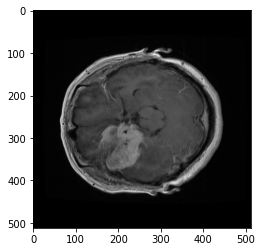

In [27]:
show = img 
plt.imshow(img, "gray")
plt.show()

In [29]:
# image processing

n_layers=1
wires=4
#rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, wires))

#device_names = ["qiskit.aer", "default.qubit", "qiskit.ibmq"]

dev4 = qml.device("default.qubit", wires=wires)
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # trainable parameter
    theta = np.pi / 2

    qml.RX(phi[i] * np.pi, wires=i)
    qml.RX(phi[i+1] * np.pi, wires=i+1)
    qml.RX(phi[i+2] * np.pi, wires=i+2)
    qml.RX(phi[i+3] * np.pi, wires=i+3)

    qml.CRZ(theta, wires=[i+1, i])
    qml.CRZ(theta, wires=[i+3, i+2])
    qml.CRX(theta, wires=[i+1, i])
    qml.CRX(theta, wires=[i+3, i+2])
    qml.CRZ(theta, wires=[i+2, i])
    qml.CRX(theta, wires=[i+2, i])
    #RandomLayers(rand_params, wires=list(range(4)))
    measurement = qml.expval(qml.PauliZ(wires=i)) # [qml.expval(qml.PauliZ(i)) for i in range(4)]

    return measurement


def QCONV1(X, image_number, image_total, step=2):
    """
    quantum convolutional layer
    """

    #H, W, CH = X.shape
    H, W = X.shape
    step2 = 4
    out = np.zeros((H//step, W//step))
    #progress = 0
    for i in range(0, W, step):
        #print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(int(((i/W+1))*100))+"% ", end="\r")
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # to speed up the calculation a bit I used the mean of each 4x4 pixels :(
            px0 = X[i:i+step2, j:j+step2].mean()
            px1 = X[i:i+step2, j+step2:j+step].mean()
            px2 = X[i+step2:i+step, j:j+step2].mean()
            px3 = X[i+step2:i+step, j+step2:j+step].mean()

            phi = np.array([px0, px1, px2, px3])
            #phi = X[i:i+2, j:j+2].flatten()
            # apply
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out


In [32]:
phi = [1, 1, 1, 1]
drawer = qml.draw(CONVCircuit)
print(drawer(phi, 4))

 0: ──RX(3.14)──╭RZ(1.57)──╭RX(1.57)──╭RZ(1.57)──╭RX(1.57)──┤ ⟨Z⟩ 
 1: ──RX(3.14)──╰C─────────╰C─────────│──────────│──────────┤     
 2: ──RX(3.14)──╭RZ(1.57)──╭RX(1.57)──╰C─────────╰C─────────┤     
 3: ──RX(3.14)──╰C─────────╰C───────────────────────────────┤     



In [ ]:
# Images processing with a Quantum Convolutional Layer
folder = "../brain_tumor_dataset/all/" # .mat files folder

start = timer()
w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
for file in directs:
    #substart = timer()
    #if file+".npz" in all64:
    #    continue
    f = h5py.File(folder+file, 'r')
    image = np.array(f.get("cjdata/image"))
    if image.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]
    NorImages = image/255
    processed = QCONV1(NorImages, str(k)+" "+file, len(directs), step)
    mask = np.array(f.get("cjdata/tumorMask"))/255
    processedMask = QCONV1(mask, str(k)+" "+file, len(directs), step)
    #processed[i, j] = Quanv(NorImages[i, j], j+1, NorImages.shape[1])
    np.savez_compressed("../brain_tumor_dataset/processed/all/"+file, image=processed, mask=processedMask, label=label)
    #subend = timer()
    #print("\n"+str(timedelta(seconds=round(subend-substart))))
    k+=1
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

In [2]:
# get processed data
folder = "../brain_tumor_dataset/processed/all/"
directs = sorted(listdir(folder))

images = []
masks = []
labels = []
i = 0
for file in directs:
    data = np.load(folder+file)
    images.append(data["image"])
    masks.append(data["mask"])
    labels.append(data["label"])
    i+=1

npimages = np.asarray(images)
nplabels = np.asarray(labels)
npmasks = np.asarray(masks)

In [5]:
npimages.shape, nplabels.shape, npmasks.shape

((1584, 64, 64), (1584,), (1584, 64, 64))

In [6]:
# Make a train/test split using 30% test size
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.30,
                                                    random_state=42)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1108, 64, 64), (476, 64, 64), (1108,), (476,))

In [8]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(4, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [9]:
q_model = Model()

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=32,
    verbose=2,
)


Epoch 1/32
70/70 - 2s - loss: 0.6463 - accuracy: 0.7780 - val_loss: 0.4625 - val_accuracy: 0.8340
Epoch 2/32
70/70 - 0s - loss: 0.3156 - accuracy: 0.9061 - val_loss: 0.3179 - val_accuracy: 0.8866
Epoch 3/32
70/70 - 0s - loss: 0.2063 - accuracy: 0.9513 - val_loss: 0.2556 - val_accuracy: 0.9118
Epoch 4/32
70/70 - 0s - loss: 0.1614 - accuracy: 0.9621 - val_loss: 0.2144 - val_accuracy: 0.9328
Epoch 5/32
70/70 - 0s - loss: 0.1269 - accuracy: 0.9765 - val_loss: 0.2016 - val_accuracy: 0.9349
Epoch 6/32
70/70 - 0s - loss: 0.1091 - accuracy: 0.9801 - val_loss: 0.1794 - val_accuracy: 0.9391
Epoch 7/32
70/70 - 0s - loss: 0.0896 - accuracy: 0.9856 - val_loss: 0.1655 - val_accuracy: 0.9454
Epoch 8/32
70/70 - 0s - loss: 0.0814 - accuracy: 0.9838 - val_loss: 0.1614 - val_accuracy: 0.9475
Epoch 9/32
70/70 - 0s - loss: 0.0700 - accuracy: 0.9910 - val_loss: 0.1532 - val_accuracy: 0.9475
Epoch 10/32
70/70 - 0s - loss: 0.0585 - accuracy: 0.9928 - val_loss: 0.1474 - val_accuracy: 0.9475
Epoch 11/32
70/70 -

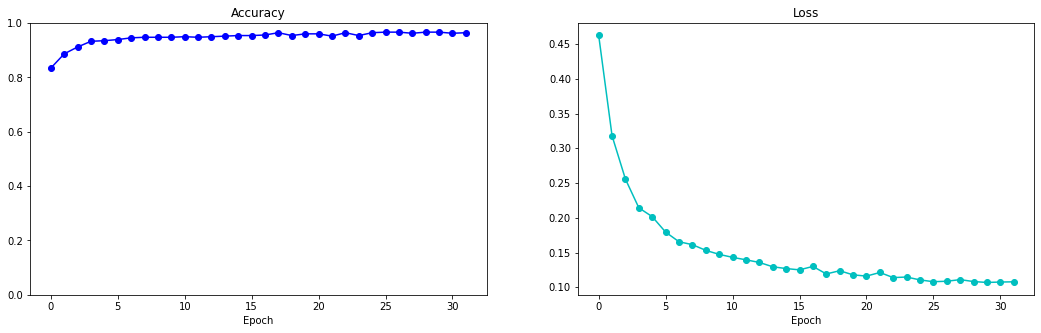

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")

ax2.plot(q_history.history["val_loss"], "-oc")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
plt.show()

In [11]:
yhat = q_model.predict(X_test)
yhat = yhat.argmax(axis=1)

In [12]:
yhat.shape, y_test.shape

((476,), (476,))

In [16]:
from sklearn.metrics import classification_report
import itertools

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

         1.0       0.88      0.76      0.81        46
         2.0       0.96      0.97      0.96       181
         3.0       0.98      1.00      0.99       249

    accuracy                           0.96       476
   macro avg       0.94      0.91      0.92       476
weighted avg       0.96      0.96      0.96       476



Confusion matrix, without normalization


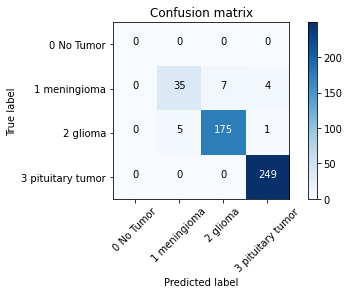

In [21]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(np.array(cnf_matrix), classes=['0 No Tumor', '1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')